In [1]:
import sys
import math
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data

In [2]:
def draw(steps, accs, losses, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot([i for i in range(steps)], losses, '-', color='#4169E1', alpha=0.8, linewidth=1)
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} Loss Chart')
    ax2.plot([i for i in range(steps)], accs, '-', color='#4169E1', alpha=0.8, linewidth=1)
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} Accuracy Chart')
    plt.show()

In [3]:
class PalindromeDataset(data.Dataset):

    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        return sys.maxsize

    def __getitem__(self, idx):
        full_palindrome = self.generate_palindrome()
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length / 2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))

In [4]:
class VanillaRNN(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.Whx = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Whh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.Wph = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.bh = nn.Parameter(torch.zeros(1, hidden_dim))
        self.bo = nn.Parameter(torch.zeros(1, output_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        h = torch.zeros(batch_size, self.hidden_dim)
        for t in range(self.seq_length):
            h = torch.tanh(torch.mm(x[:, t].reshape(-1, 1), self.Whx) + torch.mm(h, self.Whh) + self.bh)
        output = torch.mm(h, self.Wph) + self.bo
        return output

In [5]:
class LSTM(nn.Module):

    def __init__(self, seq_length, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.Wgx = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Wgh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bg = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wix = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Wih = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bi = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wfx = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Wfh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bf = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wox = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.Woh = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.bo = nn.Parameter(torch.randn(1, hidden_dim))
        self.Wph = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.bp = nn.Parameter(torch.randn(1, output_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        h = torch.zeros(batch_size, self.hidden_dim)
        c = torch.zeros(batch_size, self.hidden_dim)
        for t in range(self.seq_length):
            xt = x[:, t].reshape(-1, 1)
            gt = torch.tanh(torch.mm(xt, self.Wgx) + torch.mm(h, self.Wgh) + self.bg)
            it = torch.sigmoid(torch.mm(xt, self.Wix) + torch.mm(h, self.Wih) + self.bi)
            ft = torch.sigmoid(torch.mm(xt, self.Wfx) + torch.mm(h, self.Wfh) + self.bf)
            ot = torch.sigmoid(torch.mm(xt, self.Wox) + torch.mm(h, self.Woh) + self.bo)
            c = gt * it + c * ft
            h = torch.tanh(c) * ot
        return torch.mm(h, self.Wph) + self.bp

In [6]:
steps = 50000
step_limit = 40000
batch_size = 128
input_dim = 1
hidden_dim = 128
output_dim = 10

In [7]:
def main(model_name, length):
    model = train(model_name, length)
    test(model, model_name, length)

In [8]:
def train(model_name, length):
    if model_name == 'VanillaRNN':
        model = VanillaRNN(length-1, input_dim, hidden_dim, output_dim)
    elif model_name == 'LSTM':
        model = LSTM(length-1, input_dim, hidden_dim, output_dim)
    else:
        raise Exception('Model name not supported!')
    losses, accs = [], []
    range_acc = []
    dataset = PalindromeDataset(length)
    data_loader = data.DataLoader(dataset, batch_size)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        batch_outputs = model(batch_inputs)
        loss = criterion(batch_outputs, batch_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.mean(np.argmax(batch_outputs.detach().numpy(), axis=1) == batch_targets.detach().numpy())
        losses.append(loss.item())
        accs.append(acc)
        if step % 2000 == 0:
            print('Step: ', step, 'Loss: ', loss.item(), 'Accuracy: ', acc)
        if step == steps - 1:
            print('Step: ', step, 'Loss: ', loss.item(), 'Accuracy: ', acc)
            break
        if step >= step_limit:
            range_acc.append(acc)
    print(f'Average accuracy steps {step_limit} - {steps}: {np.mean(range_acc)}')
    draw(steps, accs, losses, model_name)
    return model

In [9]:
def test(model, model_name, length):
    model.eval()
    dataset = PalindromeDataset(length)
    data_loader = data.DataLoader(dataset, batch_size=128)
    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        batch_outputs = model(batch_inputs)
        acc = np.mean(np.argmax(batch_outputs.detach().numpy(), axis=1) == batch_targets.detach().numpy())
        print(f'{model_name} Test Accuracy :', acc)
        break

Step:  0 Loss:  15.70534896850586 Accuracy:  0.125
Step:  2000 Loss:  0.06898149847984314 Accuracy:  0.984375
Step:  4000 Loss:  0.021910876035690308 Accuracy:  1.0
Step:  6000 Loss:  0.03117651678621769 Accuracy:  0.9921875
Step:  8000 Loss:  0.002866927068680525 Accuracy:  1.0
Step:  10000 Loss:  0.0003673436585813761 Accuracy:  1.0
Step:  12000 Loss:  0.0002690877008717507 Accuracy:  1.0
Step:  14000 Loss:  0.0005908993189223111 Accuracy:  1.0
Step:  16000 Loss:  3.10319010168314e-05 Accuracy:  1.0
Step:  18000 Loss:  0.00013764032337348908 Accuracy:  1.0
Step:  20000 Loss:  5.995761057420168e-06 Accuracy:  1.0
Step:  22000 Loss:  1.6004629287635908e-05 Accuracy:  1.0
Step:  24000 Loss:  8.279769099317491e-05 Accuracy:  1.0
Step:  26000 Loss:  1.679184424574487e-05 Accuracy:  1.0
Step:  28000 Loss:  3.737950828508474e-05 Accuracy:  1.0
Step:  30000 Loss:  9.313224857976365e-09 Accuracy:  1.0
Step:  32000 Loss:  4.2840775904551265e-07 Accuracy:  1.0
Step:  34000 Loss:  2.057272240563

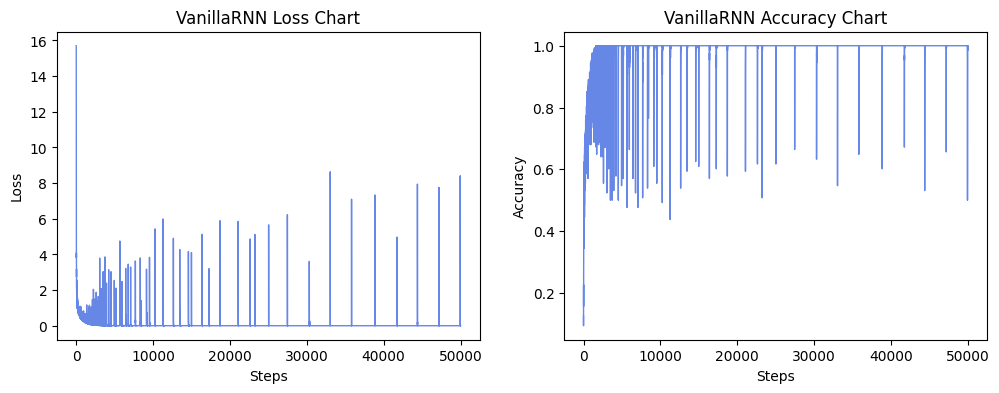

VanillaRNN Test Accuracy : 1.0


In [10]:
length = 5
main("VanillaRNN", length)

Step:  0 Loss:  6.33057975769043 Accuracy:  0.0703125
Step:  2000 Loss:  1.6065284853539197e-06 Accuracy:  1.0
Step:  4000 Loss:  3.2968776508823794e-07 Accuracy:  1.0
Step:  6000 Loss:  1.8992537661688402e-05 Accuracy:  1.0
Step:  8000 Loss:  9.313224857976365e-09 Accuracy:  1.0
Step:  10000 Loss:  3.0919872529011627e-07 Accuracy:  1.0
Step:  12000 Loss:  9.313225191043273e-10 Accuracy:  1.0
Step:  14000 Loss:  2.0489094865183688e-08 Accuracy:  1.0
Step:  16000 Loss:  2.00322915588913e-06 Accuracy:  1.0
Step:  18000 Loss:  6.51925757821914e-09 Accuracy:  1.0
Step:  20000 Loss:  6.798653373607522e-08 Accuracy:  1.0
Step:  22000 Loss:  2.071203880404937e-06 Accuracy:  1.0
Step:  24000 Loss:  4.656612428988183e-09 Accuracy:  1.0
Step:  26000 Loss:  3.49245340203197e-07 Accuracy:  1.0
Step:  28000 Loss:  5.587935003603661e-09 Accuracy:  1.0
Step:  30000 Loss:  2.7939672797572257e-09 Accuracy:  1.0
Step:  32000 Loss:  6.239856986667291e-08 Accuracy:  1.0
Step:  34000 Loss:  3.6851349705102

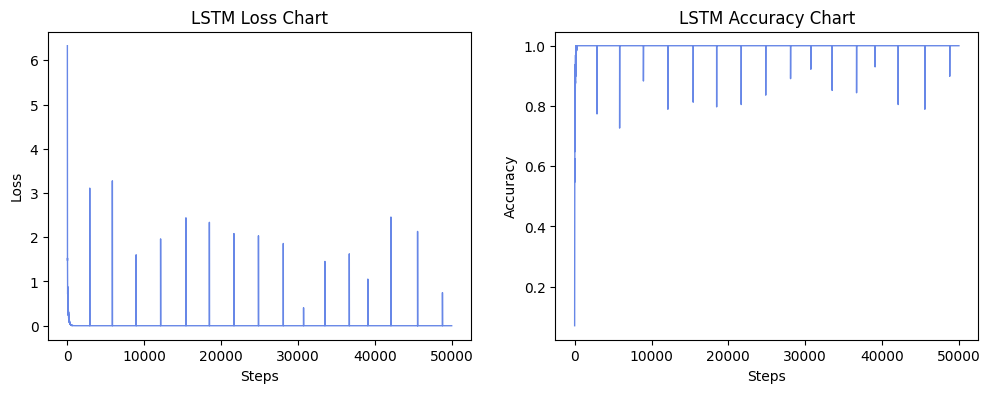

LSTM Test Accuracy : 1.0


In [11]:
length = 5
main("LSTM", length)

Step:  0 Loss:  16.942338943481445 Accuracy:  0.0859375
Step:  2000 Loss:  5.973904132843018 Accuracy:  0.09375
Step:  4000 Loss:  2.1476986408233643 Accuracy:  0.234375
Step:  6000 Loss:  1.8937902450561523 Accuracy:  0.3125
Step:  8000 Loss:  2.000152587890625 Accuracy:  0.2421875
Step:  10000 Loss:  1.8243792057037354 Accuracy:  0.265625
Step:  12000 Loss:  1.5532256364822388 Accuracy:  0.40625
Step:  14000 Loss:  1.8013850450515747 Accuracy:  0.328125
Step:  16000 Loss:  1.5498019456863403 Accuracy:  0.3671875
Step:  18000 Loss:  1.4006410837173462 Accuracy:  0.40625
Step:  20000 Loss:  1.2228131294250488 Accuracy:  0.4921875
Step:  22000 Loss:  1.1060551404953003 Accuracy:  0.4609375
Step:  24000 Loss:  1.0528874397277832 Accuracy:  0.5546875
Step:  26000 Loss:  1.2600823640823364 Accuracy:  0.4453125
Step:  28000 Loss:  1.0084755420684814 Accuracy:  0.4765625
Step:  30000 Loss:  0.9844813346862793 Accuracy:  0.5859375
Step:  32000 Loss:  0.7038825750350952 Accuracy:  0.71875
Step

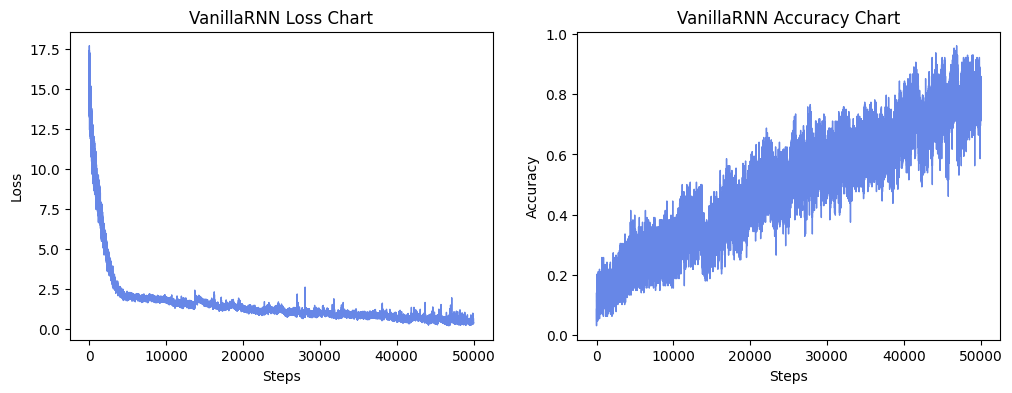

VanillaRNN Test Accuracy : 0.8203125


In [12]:
length = 10
main("VanillaRNN", length)

Step:  0 Loss:  8.456743240356445 Accuracy:  0.078125
Step:  2000 Loss:  0.021996794268488884 Accuracy:  0.9921875
Step:  4000 Loss:  0.0011693990090861917 Accuracy:  1.0
Step:  6000 Loss:  0.00016551109729334712 Accuracy:  1.0
Step:  8000 Loss:  6.742425466654822e-05 Accuracy:  1.0
Step:  10000 Loss:  0.00031466319342143834 Accuracy:  1.0
Step:  12000 Loss:  0.0003172626602463424 Accuracy:  1.0
Step:  14000 Loss:  1.1296285265416373e-05 Accuracy:  1.0
Step:  16000 Loss:  1.6819607253637514e-06 Accuracy:  1.0
Step:  18000 Loss:  8.735732990317047e-07 Accuracy:  1.0
Step:  20000 Loss:  3.2782002108433517e-06 Accuracy:  1.0
Step:  22000 Loss:  5.919435352552682e-05 Accuracy:  1.0
Step:  24000 Loss:  0.0001272386434720829 Accuracy:  1.0
Step:  26000 Loss:  5.18015403940808e-05 Accuracy:  1.0
Step:  28000 Loss:  1.2628645436052466e-06 Accuracy:  1.0
Step:  30000 Loss:  1.399758275510976e-06 Accuracy:  1.0
Step:  32000 Loss:  8.281291229650378e-06 Accuracy:  1.0
Step:  34000 Loss:  2.069346

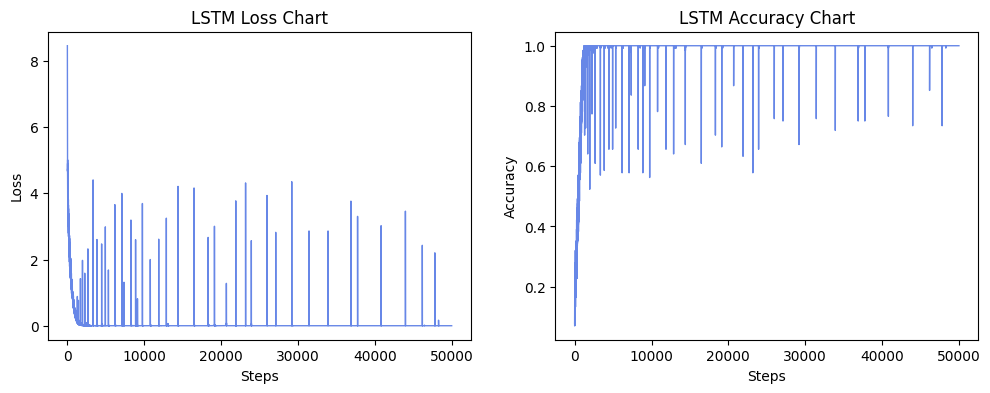

LSTM Test Accuracy : 1.0


In [13]:
length = 10
main("LSTM", length)

Step:  0 Loss:  15.924747467041016 Accuracy:  0.1796875
Step:  2000 Loss:  4.9273457527160645 Accuracy:  0.125
Step:  4000 Loss:  2.536255121231079 Accuracy:  0.09375
Step:  6000 Loss:  2.2867958545684814 Accuracy:  0.1796875
Step:  8000 Loss:  2.274440050125122 Accuracy:  0.171875
Step:  10000 Loss:  2.271008014678955 Accuracy:  0.1640625
Step:  12000 Loss:  2.311211109161377 Accuracy:  0.0859375
Step:  14000 Loss:  2.3082120418548584 Accuracy:  0.1015625
Step:  16000 Loss:  2.3459362983703613 Accuracy:  0.09375
Step:  18000 Loss:  2.335526466369629 Accuracy:  0.0625
Step:  20000 Loss:  2.326127767562866 Accuracy:  0.078125
Step:  22000 Loss:  2.266596555709839 Accuracy:  0.1484375
Step:  24000 Loss:  2.326293468475342 Accuracy:  0.0859375
Step:  26000 Loss:  2.3298511505126953 Accuracy:  0.0859375
Step:  28000 Loss:  2.3112523555755615 Accuracy:  0.1171875
Step:  30000 Loss:  2.2726175785064697 Accuracy:  0.1328125
Step:  32000 Loss:  2.3155012130737305 Accuracy:  0.109375
Step:  340

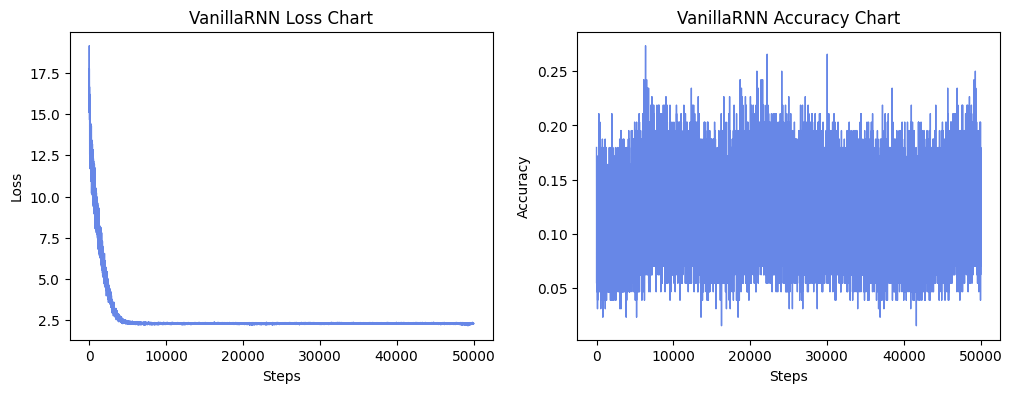

VanillaRNN Test Accuracy : 0.140625


In [14]:
length = 15
main("VanillaRNN", length)

Step:  0 Loss:  6.3816304206848145 Accuracy:  0.0703125
Step:  2000 Loss:  1.9299362897872925 Accuracy:  0.25
Step:  4000 Loss:  0.1472966969013214 Accuracy:  0.9609375
Step:  6000 Loss:  0.03190506994724274 Accuracy:  0.9921875
Step:  8000 Loss:  0.0006347112939693034 Accuracy:  1.0
Step:  10000 Loss:  0.0002293458383064717 Accuracy:  1.0
Step:  12000 Loss:  9.822567517403513e-05 Accuracy:  1.0
Step:  14000 Loss:  7.213542266981676e-05 Accuracy:  1.0
Step:  16000 Loss:  1.080294168787077e-05 Accuracy:  1.0
Step:  18000 Loss:  6.083225162001327e-05 Accuracy:  1.0
Step:  20000 Loss:  8.496076588926371e-06 Accuracy:  1.0
Step:  22000 Loss:  0.00038923037936910987 Accuracy:  1.0
Step:  24000 Loss:  0.00014052492042537779 Accuracy:  1.0
Step:  26000 Loss:  3.296852128187311e-06 Accuracy:  1.0
Step:  28000 Loss:  1.0048944432128337e-06 Accuracy:  1.0
Step:  30000 Loss:  2.065649141513859e-06 Accuracy:  1.0
Step:  32000 Loss:  3.241786180296913e-05 Accuracy:  1.0
Step:  34000 Loss:  4.169451

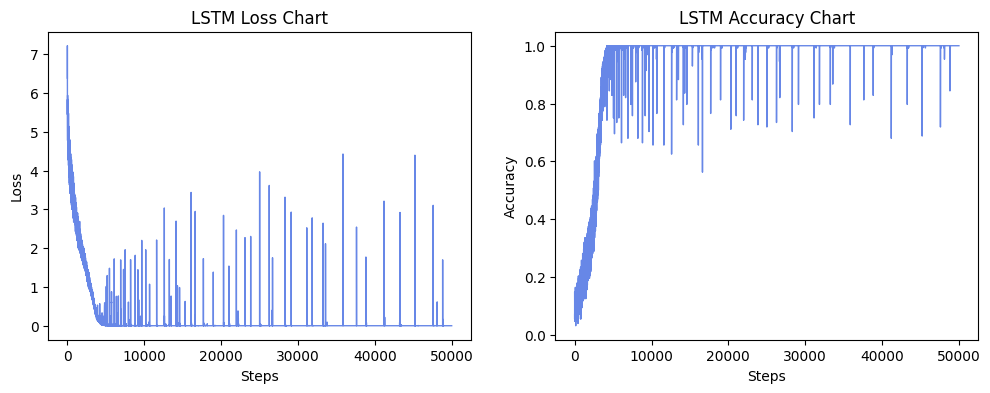

LSTM Test Accuracy : 1.0


In [15]:
length = 15
main("LSTM", length)

Step:  0 Loss:  15.973852157592773 Accuracy:  0.1328125
Step:  2000 Loss:  5.871718406677246 Accuracy:  0.0625
Step:  4000 Loss:  2.4479520320892334 Accuracy:  0.0859375
Step:  6000 Loss:  2.293243169784546 Accuracy:  0.171875
Step:  8000 Loss:  2.3221051692962646 Accuracy:  0.1015625
Step:  10000 Loss:  2.288540840148926 Accuracy:  0.1015625
Step:  12000 Loss:  2.2978196144104004 Accuracy:  0.109375
Step:  14000 Loss:  2.307795524597168 Accuracy:  0.1171875
Step:  16000 Loss:  2.3190724849700928 Accuracy:  0.1015625
Step:  18000 Loss:  2.3111727237701416 Accuracy:  0.125
Step:  20000 Loss:  2.290520668029785 Accuracy:  0.15625
Step:  22000 Loss:  2.298147678375244 Accuracy:  0.1484375
Step:  24000 Loss:  2.301682472229004 Accuracy:  0.0859375
Step:  26000 Loss:  2.28283953666687 Accuracy:  0.15625
Step:  28000 Loss:  2.2895278930664062 Accuracy:  0.109375
Step:  30000 Loss:  2.2991998195648193 Accuracy:  0.125
Step:  32000 Loss:  2.2937819957733154 Accuracy:  0.078125
Step:  34000 Los

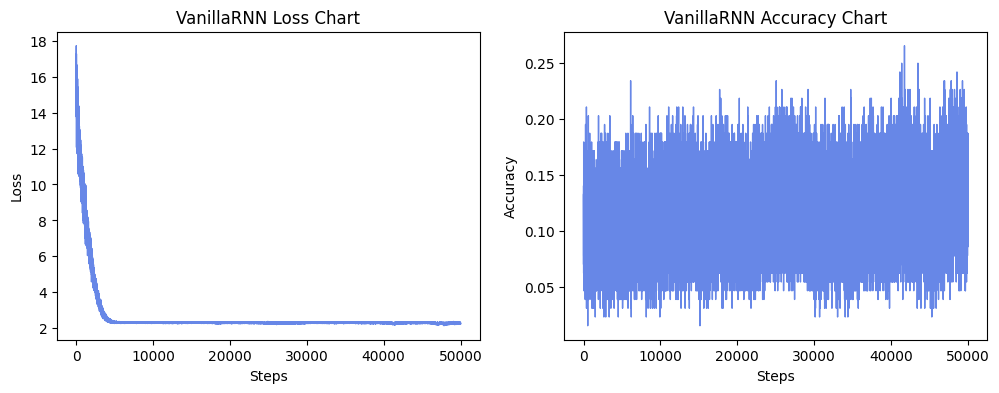

VanillaRNN Test Accuracy : 0.1953125


In [16]:
length = 20
main("VanillaRNN", length)

Step:  0 Loss:  8.166326522827148 Accuracy:  0.09375
Step:  2000 Loss:  2.680523633956909 Accuracy:  0.1484375
Step:  4000 Loss:  2.4754459857940674 Accuracy:  0.0546875
Step:  6000 Loss:  2.2835092544555664 Accuracy:  0.1796875
Step:  8000 Loss:  1.669158935546875 Accuracy:  0.4140625
Step:  10000 Loss:  0.7012922167778015 Accuracy:  0.75
Step:  12000 Loss:  0.22973191738128662 Accuracy:  0.953125
Step:  14000 Loss:  0.01898360438644886 Accuracy:  1.0
Step:  16000 Loss:  0.030686261132359505 Accuracy:  0.9921875
Step:  18000 Loss:  0.002915129065513611 Accuracy:  1.0
Step:  20000 Loss:  0.00039186724461615086 Accuracy:  1.0
Step:  22000 Loss:  0.00012635682651307434 Accuracy:  1.0
Step:  24000 Loss:  0.00013949788990430534 Accuracy:  1.0
Step:  26000 Loss:  0.0001095003099180758 Accuracy:  1.0
Step:  28000 Loss:  0.00013474607840180397 Accuracy:  1.0
Step:  30000 Loss:  0.0001570782478665933 Accuracy:  1.0
Step:  32000 Loss:  3.277917858213186e-05 Accuracy:  1.0
Step:  34000 Loss:  2.

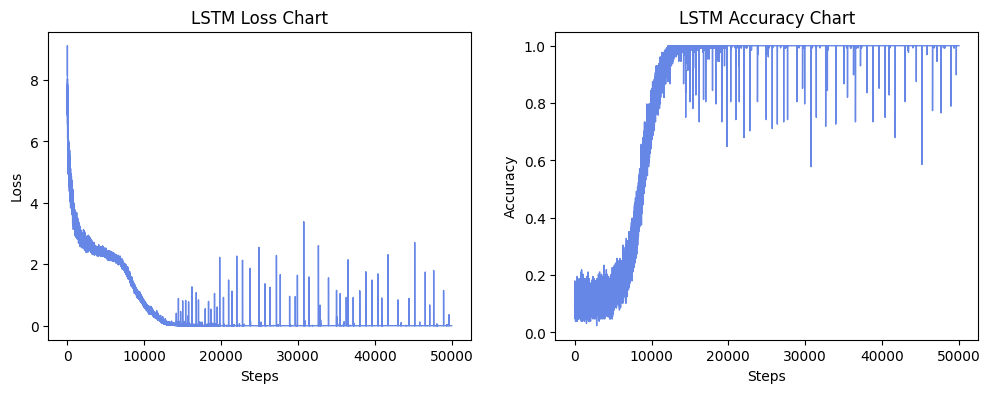

LSTM Test Accuracy : 1.0


In [17]:
length = 20
main("LSTM", length)